# NMC Update Plots

In [449]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import json
import xarray as xr
import pint_xarray
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [450]:
def location_label(site):
    return site['river'] + ' ' + site['location']

def compute_river_load(ds, site, nested=True):
    
    site_load = ds.sel(site_no=site['gage_id'])
    site_load = site_load.drop_vars('site_no')
    site_load = site_load * site['scale_factor']

    upstream_gage = site.get('upstream_gage')
    
    if upstream_gage and nested:
        upstream_load = ds.sel(site_no=upstream_gage).drop_vars('site_no')
        site_load = site_load - upstream_load
        
    site_load = site_load.assign_coords(coords={'river':location_label(site)})
    
    return site_load


def compute_network_loads(ds, network, nested=True):
    rivers = []
    
    for site in network:
        if site['gage_id'] in ds.site_no:
            rivers.append(compute_river_load(ds, site, nested))
        
    return xr.concat(rivers, dim='river')
    #return rivers

def labels(network):
    labels = []
    for site in network:
        nested = site.get('nested')

        if nested is None or nested==False:
            #print(nested)
            labels.append(location_label(site))
            
    return labels

def gages(network):
    labels = []
    for site in network:
        nested = site.get('nested')

        if nested is None or nested==False:
            #print(nested)
            labels.append(site['gage_id'])
            
    return labels
#def compute_network_total(ds, network):
#    pass

def kg_to_lbs(x):
    return x * 2.20462

def kg_to_kt(x):
    return x * 1.0e-6

In [451]:
supergage_metadata = '../../data/supergage_network.json'
ambient_metadata = '../../data/ambient_network.json'

with open(supergage_metadata) as f:
    supergage_network = json.load(f)
    
with open(ambient_metadata) as f:
    ambient_network = json.load(f)

supergage_ds = xr.load_dataset('../../data/supergage_annual_loads.netcdf')
ambient_ds = xr.load_dataset('../../data/ambient_wrtdsk_annual_loads.netcdf')

In [452]:
labels(supergage_network)
#gages(supergage_network) 

['Rock at Joslin',
 'Green at Geneseo',
 'Illinois at Valley City',
 'Kaskaskia at Venedy Station',
 'Big Muddy at Murphysboro',
 'Little Wabash at Carmi',
 'Embarras at Ste. Mairie',
 'Vermilion at Danville']

In [434]:
supergage_loads = compute_network_loads(supergage_ds.dropna(dim='year'), supergage_network, nested=False)

ambient_loads = compute_network_loads(ambient_ds.sel(site_no=gages(ambient_network)).dropna(dim='year'),
                                      ambient_network, nested=False)

units = {'nitrate': 'kg', 'phosphorus': 'kg'}
supergage_loads = supergage_loads.pint.quantify(units)
ambient_loads = ambient_loads.pint.quantify(units)

In [878]:
from matplotlib.offsetbox import AnchoredText

def title_axes(ax):
    ax.set_xlabel( ax.get_xlabel().title())
    ax.set_ylabel( ax.get_ylabel().title())
    
    
#def annotate_difference(baseline_mean, recent_mean, loc, ax):
def annotate_difference(delta, loc, ax):
    if loc is None:
        loc='upper right'
        
    #delta = (recent_mean - baseline_mean)/ baseline_mean * 100
    annotate_text = "Change: {:.1f}%".format(delta.values)
    at = AnchoredText(annotate_text, prop=dict(size=10), frameon=False, loc=loc)
    ax.add_artist(at)
    
    
def mean_and_se(ds, dim):
    mean = ds.mean(dim=dim)
    se = ds.std(dim=dim) / np.sqrt(ds.sizes[dim])
    return mean, se

    
def plot_mean_error(ds, period, color, ax, linewidth=2, extend=None):
    # ds.sel(river=labels(network1)).sum(dim='river').sel(year=ds.year.dt.year.isin(period))    
    mean, se = mean_and_se(ds, dim='year')

    xmin = pd.to_datetime(str(period[0]))
    xmax = pd.to_datetime(str(period[-1]))
    ax.hlines(y=mean, xmin=xmin, xmax=xmax, linewidth=linewidth, color=color)
    ax.hlines(y=mean+1.96*se, xmin=xmin, xmax=xmax, linewidth=1, ls='-', color=color)
    ax.hlines(y=mean-1.96*se, xmin=xmin, xmax=xmax, linewidth=1, ls='-', color=color)
    
    if extend:
        extend =  pd.to_datetime(str(extend))
        ax.hlines(y=mean, xmin=xmax, xmax=extend, linewidth=linewidth, ls='dotted', color=color)


def running_average_plot(ds1,
                         period1,
                         period2,
                         ds2=None, 
                         ax=None,
                         loc=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    p1_ds = ds1.sel(year=ds1.year.dt.year.isin(period1))
    p1_mean = p1_ds.mean()

    if ds2 is None:
        ds2 = ds1

    p2_ds = ds2.sel(year=ds2.year.dt.year.isin(period2))
    p2_mean = p2_ds.mean()
   
    plot_mean_error(ds=p1_ds,
                    period=period1,
                    color='red',
                    extend=period2[0],
                    ax=ax)
    
    plot_mean_error(ds=p2_ds,
                    period=period2,
                    color='black',
                    ax=ax)

    ds1.plot(marker='o', color='k', linestyle='None', markeredgecolor='k', markerfacecolor='None', ax=ax)
    ds2.plot(marker='o', color='k', linestyle='None', markeredgecolor='k', markerfacecolor='k', ax=ax)

    #annotate_difference(p1_mean, p2_mean, loc, ax)
    annotate_difference(p2_mean, loc, ax)
    title_axes(ax)



In [879]:
fig_w = 5.51181 #inches
fig_h = 4 #inches

C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


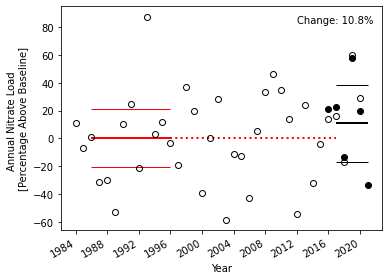

In [880]:
# timeseries of % of baseline load

baseline_years = np.arange(1986,1996+1)
study_years = np.arange(2017,2021+1) #base this on data
parameter='nitrate'; loc='upper right'
units='percentage'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

baseline_mean_load = ambient_loads[parameter].sel(river=labels(ambient_network)).sum(dim='river').sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean()

ambient_total_load = ambient_loads[parameter].sel(river=labels(ambient_network)).sum(dim='river') / baseline_mean_load * 100 - 100
supergage_total_load = supergage_loads[parameter].sel(river=labels(supergage_network)).sum(dim='river') / baseline_mean_load * 100 - 100

running_average_plot(ds1=ambient_total_load,
                     period1=baseline_years,
                     period2=study_years,
                     ds2=supergage_total_load,
                     loc=loc,
                     ax=ax)

#ax.set_ylabel(f'Annual {parameter.title()} Load\n[{units} from baseline] ')
ax.set_ylabel(f'Annual {parameter} load \n[{units} above baseline]'.title())

fig.tight_layout()
fig.savefig(f'../../figures/{parameter}_timeseries.pdf')

C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


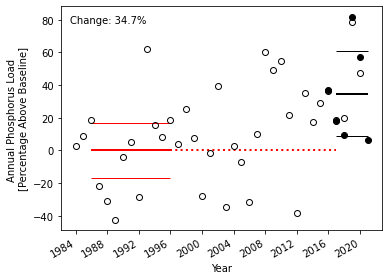

In [882]:
# timeseries of % of baseline load

baseline_years = np.arange(1986,1996+1)
study_years = np.arange(2017,2021+1) #base this on data
parameter='phosphorus'; loc='upper left'
units='percentage'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

baseline_mean_load = ambient_loads[parameter].sel(river=labels(ambient_network)).sum(dim='river').sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean()

ambient_total_load = ambient_loads[parameter].sel(river=labels(ambient_network)).sum(dim='river') / baseline_mean_load * 100 - 100
supergage_total_load = supergage_loads[parameter].sel(river=labels(supergage_network)).sum(dim='river') / baseline_mean_load * 100 - 100

running_average_plot(ds1=ambient_total_load,
                     period1=baseline_years,
                     period2=study_years,
                     ds2=supergage_total_load,
                     loc=loc,
                     ax=ax)

#ax.set_ylabel(f'Annual {parameter.title()} Load\n[{units} from baseline] ')
ax.set_ylabel(f'Annual {parameter} load \n[{units} above baseline]'.title())

fig.tight_layout()
fig.savefig(f'../../figures/{parameter}_timeseries.pdf')

C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


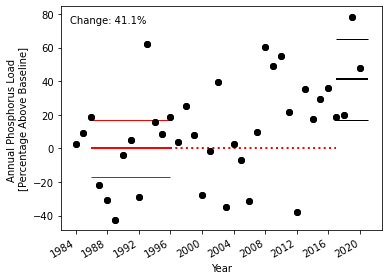

In [883]:
# ambient only
baseline_years = np.arange(1986,1996+1)
ambient_study_years = np.arange(2016,2021) #base this on data
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

baseline_mean_load = ambient_loads[parameter].sel(river=labels(ambient_network)).sum(dim='river').sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean()

ambient_total_load = ambient_loads[parameter].sel(river=labels(ambient_network)).sum(dim='river') / baseline_mean_load * 100 - 100
supergage_total_load = supergage_loads[parameter].sel(river=labels(supergage_network)).sum(dim='river') / baseline_mean_load * 100 - 100

running_average_plot(ds1=ambient_total_load,
                     period1=baseline_years,
                     period2=study_years,
                     #ds2=supergage_total_load,
                     loc=loc,
                     ax=ax)

#ax.set_ylabel(f'Annual {parameter.title()} Load\n[{units} from baseline] ')
ax.set_ylabel(f'Annual {parameter} load \n[{units} above baseline]'.title())

fig.tight_layout()
#fig.savefig(f'../../figures/{parameter}_timeseries.pdf')

In [884]:
def plot_difference(period1_ds, period2_ds, ax=None, color='k'):
    '''
    ds1 = ambient_loads[parameter].sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean(dim='year')
    ds2 = supergage_loads[parameter].sel(year=supergage_loads.year.dt.year.isin(study_years)).mean(dim='year')
    '''
    if ax is None:
        fig, ax = plt.subplots()
    
    mean1, se1 = mean_and_se(period1_ds, dim='year')
    mean2, se2 = mean_and_se(period2_ds, dim='year')#ds.mean()
    
    difference = (mean2 - mean1).to_series()
    difference_se = np.sqrt(se1**2 + se2**2)
    
    #units = period1_ds.pint.units
    title = period1_ds.name.title()
    
    difference.plot.bar(ax=ax, yerr=difference_se*1.96, color=color, edgecolor='k', capsize=4)
    
    ax.set_ylabel(f'{title} [{units}]')
    ax.set_xlabel('')
    ax.axhline(y=0, lw=1, color='k')
    
    
def plot_change_by_basin(period1_ds, period2_ds, ax=None, color='k', statewide=False):
    '''
    ds1 = ambient_loads[parameter].sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean(dim='year')
    ds2 = supergage_loads[parameter].sel(year=supergage_loads.year.dt.year.isin(study_years)).mean(dim='year')
    '''
    if ax is None:
        fig, ax = plt.subplots()
        
        
    # compute standard error of baseline
    #(p1-p2) / p3
    # first compute error in p1-p2
    mean1, se1 = mean_and_se(period1_ds, dim='year')
    mean2, se2 = mean_and_se(period2_ds, dim='year')#ds.mean()
    
    difference = (mean2 - mean1).to_series()
    difference_se = np.sqrt(se1**2 + se2**2)
    #import pdb; pdb.set_trace()
    div = mean1
    
    if statewide:
        div = mean1.sum()
        
    difference = difference/div.values * 100
    difference_se = difference_se/div.values * 100
        
    #title = period1_ds.name.title()
    
    difference.plot.bar(ax=ax, yerr=difference_se*1.96, color=color, edgecolor='k', capsize=4)
    
    #ax.set_ylabel(f'{title} [{units}]')
    ax.set_xlabel('')
    ax.axhline(y=0, lw=1, color='k')

C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


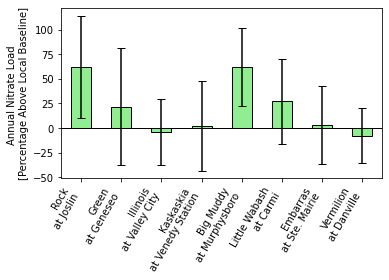

In [885]:
parameter = 'nitrate'
units = 'percentage'
baseline_years = np.arange(1986,1996+1)
study_years = np.arange(2017,2021+1) 


ds1 = ambient_loads[parameter].sel(year=ambient_loads.year.dt.year.isin(baseline_years))
ds2 = supergage_loads[parameter].sel(year=supergage_loads.year.dt.year.isin(study_years))


fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(ds1, ds2, color='lightgreen', ax=ax, statewide=False)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
#ax.set_ylabel(f'{parameter.title()}\n Relative to Baseline\n[{ds1.pint.units}]')
ax.set_ylabel(f'Annual {parameter} load \n[{units} above local baseline]'.title())

fig.tight_layout()
fig.savefig(f'../../figures/{parameter}_relative_to_local_baseline_by_river.pdf')

C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


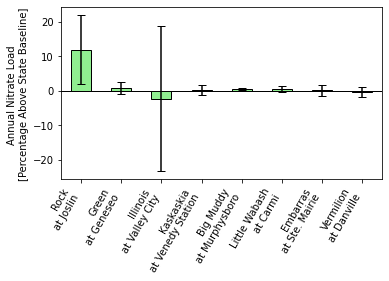

In [886]:
parameter = 'nitrate'
units = 'percentage'
baseline_years = np.arange(1986,1996+1)
study_years = np.arange(2017,2021+1) 


ds1 = ambient_loads[parameter].sel(year=ambient_loads.year.dt.year.isin(baseline_years))
ds2 = supergage_loads[parameter].sel(year=supergage_loads.year.dt.year.isin(study_years))


fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(ds1, ds2, color='lightgreen', ax=ax, statewide=True)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
#ax.set_ylabel(f'{parameter.title()}\n Relative to Baseline\n[{ds1.pint.units}]')
ax.set_ylabel(f'Annual {parameter} load \n[{units} above state baseline]'.title())

fig.tight_layout()
fig.savefig(f'../../figures/{parameter}_relative_to_state_baseline_by_river.pdf')

C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


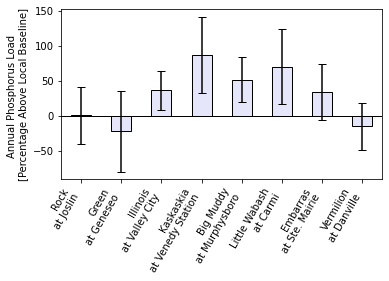

In [887]:
parameter = 'phosphorus'
units = 'percentage'
baseline_years = np.arange(1986,1996+1)
study_years = np.arange(2017,2021+1) 


ds1 = ambient_loads[parameter].sel(year=ambient_loads.year.dt.year.isin(baseline_years))
ds2 = supergage_loads[parameter].sel(year=supergage_loads.year.dt.year.isin(study_years))


fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(ds1, ds2, color='lavender', ax=ax, statewide=False)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
#ax.set_ylabel(f'{parameter.title()}\n Relative to Baseline\n[{ds1.pint.units}]')
ax.set_ylabel(f'Annual {parameter} load \n[{units} above local baseline]'.title())

fig.tight_layout()
fig.savefig(f'../../figures/{parameter}_relative_to_local_baseline_by_river.pdf')

C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


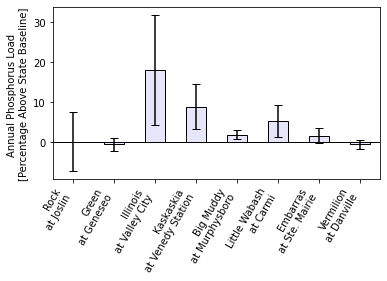

In [889]:
parameter = 'phosphorus'
units = 'percentage'
baseline_years = np.arange(1986,1996+1)
study_years = np.arange(2017,2021+1) 


ds1 = ambient_loads[parameter].sel(year=ambient_loads.year.dt.year.isin(baseline_years))
ds2 = supergage_loads[parameter].sel(year=supergage_loads.year.dt.year.isin(study_years))
#ds2 = ambient_loads[parameter].sel(year=ambient_loads.year.dt.year.isin(study_years))



fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(ds1, ds2, color='lavender', ax=ax, statewide=True)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
#ax.set_ylabel(f'{parameter.title()}\n Relative to Baseline\n[{ds1.pint.units}]')
ax.set_ylabel(f'Annual {parameter} load \n[{units} above state baseline]'.title())

fig.tight_layout()
fig.savefig(f'../../figures/{parameter}_relative_to_state_baseline_by_river.pdf')

# Flow adjusted loads

In [851]:
#flow correction
from dataretrieval import nwis
# begin by downloading flow datga
ambient_gages = gages(ambient_network)
supergage_gages = gages(supergage_network)

In [852]:
start = ambient_loads.year.dt.strftime('%Y')[0] + '-10-01'
start = str(start.values)
end = '2021-09-30'

df, _ = nwis.get_dv(sites=ambient_gages, start=start, end=end, parameterCd='00060')
df = df.rename({'00060_Mean':'mean flow [cfs]'}, axis=1).drop('00060_Mean_cd', axis=1)

#remove timezone because xarray doesn't know how to handle it yet (bug)
df = df.reset_index()
df['datetime'] = df['datetime'].values
df = df.set_index(['site_no','datetime'])

flow_ds = df.to_xarray()
flow_ds['water_year'] = flow_ds.datetime.dt.year.where(flow_ds.datetime.dt.month < 10, flow_ds.datetime.dt.year + 1)

# compute mean daily flow for each WY
# TODO make correction for missing periods
flow_wy = flow_ds.groupby('water_year').mean()#.pint.quantify({'flow': 'cfs'})
flow_wy['water_year'] = pd.to_datetime(flow_wy['water_year'], format='%Y').values
flow_wy = flow_wy.rename({'water_year':'year'})

C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


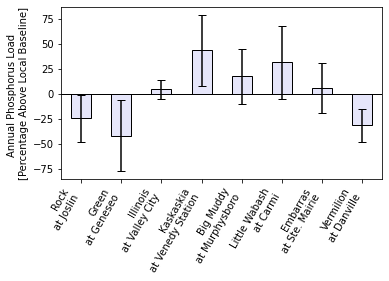

In [858]:
#XXX STILL A WORK IN PROGRESS

# flow adjusted load by basin
parameter = 'phosphorus'
units = 'percentage'
baseline_years = np.arange(1986,1996+1)
study_years = np.arange(2017,2021+1) 

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

ds1 = ambient_loads[parameter].sel(year=ambient_loads.year.dt.year.isin(baseline_years))  / ambient_flows.sum(dim='river')['mean flow [cfs]']
ds2 = supergage_loads[parameter].sel(year=supergage_loads.year.dt.year.isin(study_years)) / ambient_flows.sum(dim='river')['mean flow [cfs]']
#ds1 = ambient_loads[parameter].sel(river=labels(ambient_network)).sum(dim='river') / ambient_flows.sum(dim='river')['mean flow [cfs]']
#ds2 = supergage_loads[parameter].sel(river=labels(supergage_network)).sum(dim='river') / ambient_flows.sum(dim='river')['mean flow [cfs]']



plot_change_by_basin(ds1, ds2, color='lavender', ax=ax, statewide=False)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
#ax.set_ylabel(f'{parameter.title()}\n Relative to Baseline\n[{ds1.pint.units}]')
ax.set_ylabel(f'Annual {parameter} load \n[{units} above local baseline]'.title())

fig.tight_layout()
fig.savefig(f'../../figures/{parameter}_flow_adjusted_relative_to_state_baseline_by_river.pdf')

In [840]:
#def normalize(ds, dim='year'):
#    return (ds - ds.mean(dim=dim)) / ds.std(dim=dim)
#
#
#ambient_flows = compute_network_loads(flow_wy, ambient_network, nested=False)
#ambient_flows_z = normalize(ambient_flows) + 1
#statewide_flows_z = normalize(ambient_flows.sum(dim='river')) + 1

In [463]:
supergage_loads[parameter].sel(river='Rock at Joslin')

Magnitude,[41847983.44180531 53920328.09012125 39100590.050706424 62600485.66789934 47319946.647607304 20655568.57315739]
Units,kilogram


C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


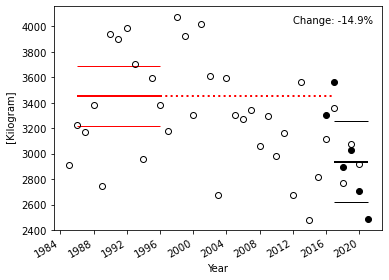

In [662]:
#simple flow adjusted (kg per cfs)
baseline_years = np.arange(1986,1996+1)
study_years = np.arange(2017,2021+1) #base this on data
parameter='nitrate'; loc='upper right'
#parameter='phosphorus'; loc='upper left'

ds1_fa = ambient_loads[parameter].sel(river=labels(ambient_network)).sum(dim='river') / ambient_flows.sum(dim='river')['mean flow [cfs]']
ds2_fa = supergage_loads[parameter].sel(river=labels(supergage_network)).sum(dim='river') / ambient_flows.sum(dim='river')['mean flow [cfs]']
#river = 'Rock at Joslin'
#ds1_fa = ambient_loads[parameter].sel(river=river) / ambient_flows.sel(river=river)['mean flow [cfs]']
#ds2_fa = supergage_loads[parameter].sel(river=river)/ ambient_flows.sel(river=river)['mean flow [cfs]']
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

running_average_plot(ds1=ds1_fa,
                     period1=baseline_years,
                     period2=study_years,
                     ds2=ds2_fa,
                     loc=loc,
                     ax=ax)

fig.tight_layout()
fig.savefig(f'../../figures/{parameter}_timeseries_flow_adjusted.pdf')

C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\thodson\Miniconda3\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


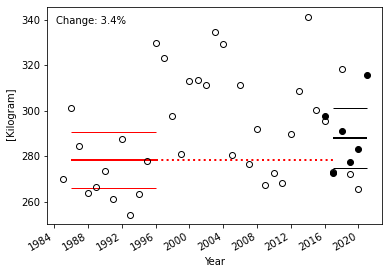

In [466]:
#simple flow adjusted (kg per cfs)
baseline_years = np.arange(1986,1996+1)
study_years = np.arange(2017,2021+1) #base this on data
#parameter='nitrate'; loc='upper right'
parameter='phosphorus'; loc='upper left'

ds1_fa = ambient_loads[parameter].sel(river=labels(ambient_network)).sum(dim='river') / ambient_flows.sum(dim='river')['mean flow [cfs]']
#ds2_fa = ambient_loads[parameter].sel(river=labels(ambient_network)).sum(dim='river') / ambient_flows.sum(dim='river')['mean flow [cfs]']
ds2_fa = supergage_loads[parameter].sel(river=labels(supergage_network)).sum(dim='river') / ambient_flows.sum(dim='river')['mean flow [cfs]']

fig, ax = plt.subplots()

running_average_plot(ds1=ds1_fa,
                     period1=baseline_years,
                     period2=study_years,
                     ds2=ds2_fa,
                     loc=loc,
                     ax=ax)

fig.savefig(f'../../figures/{parameter}_timeseries_flow_adjusted.pdf')

# scratch# change from baseline
parameter = 'nitrate'
baseline_years = np.arange(1986,1996+1)
study_years = np.arange(2017,2021) #base this on data


ds1 = ambient_loads[parameter].sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean(dim='year')
ds2 = supergage_loads[parameter].sel(year=supergage_loads.year.dt.year.isin(study_years)).mean(dim='year')

plot_difference_by_river(ds1, ds2, color='k')

In [ ]:
# change from baseline
parameter = 'nitrate'
baseline_years = np.arange(1986,1996+1)
study_years = np.arange(2017,2021) #base this on data


ds1 = ambient_loads[parameter].sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean(dim='year')
ds2 = supergage_loads[parameter].sel(year=supergage_loads.year.dt.year.isin(study_years)).mean(dim='year')

plot_difference_by_river(ds1, ds2, color='k')